In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from load_dataset import load_hand_written_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer
from util.utils import learning_curve_with_cross_validation
from util.utils import perform_grid_search
from util.utils import best_model_test_set_metrics 
from sklearn.tree import plot_tree
# fix all random seeds
RANDOM_SEED = 42
RANDOM_SEEDS = [42, 43, 44, 45, 46]
np.random.seed(RANDOM_SEED)

%load_ext autoreload
%autoreload 2

df = load_hand_written_digits()

# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=df['target'])
X = df.drop('target', axis=1)
y = df['target']

# Preprocess the data for kNN classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 1. Clustering

## 1.1 Dendrogram

In [4]:
# Let's apply clustering on the dataset: Expectation Maximization and KMeans

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

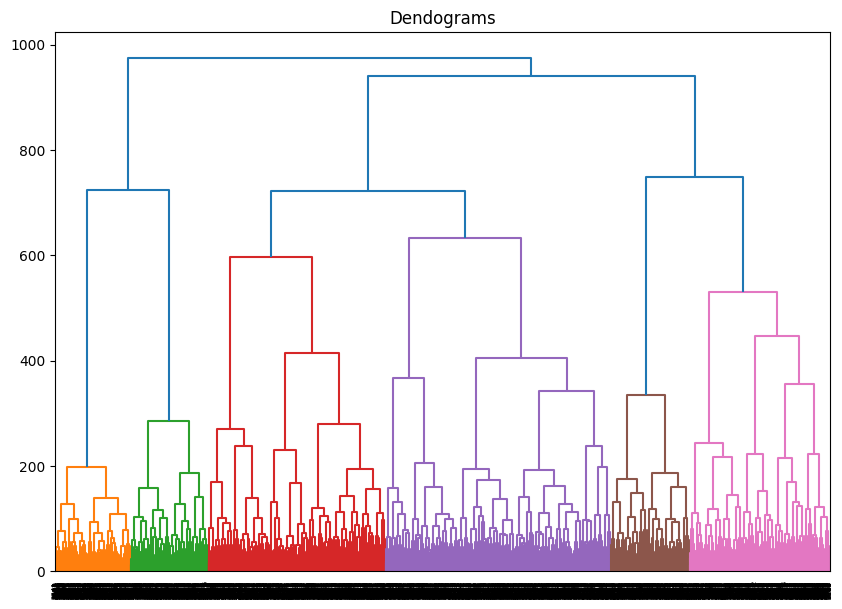

In [5]:
# first apply agglomerative clustering, visualize the hierarchy and then apply kmeans
from sklearn.cluster import AgglomerativeClustering

# clf = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
# clf.fit(X_train_scaled)
# X_train_scaled['cluster'] = clf.labels_

# visualize dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))



## 1.2 K-medoids

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [04:06<00:00,  8.81s/it]


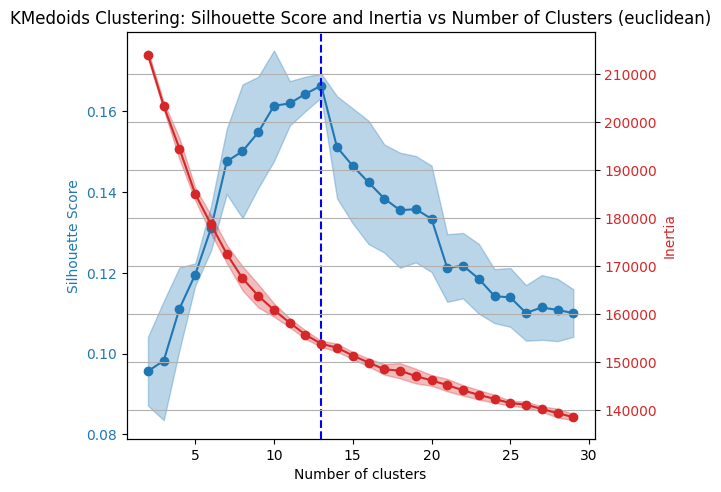

In [20]:
from util.utils import k_medoid_multi_seed

# Apply k-medoids clustering
kmedoids_train_sil_mean, kmedoids_train_sil_std, kmedoids_train_wcss_mean, kmedoids_train_wcss_std = k_medoid_multi_seed(X, k_min=2, k_max=30, metric="euclidean")

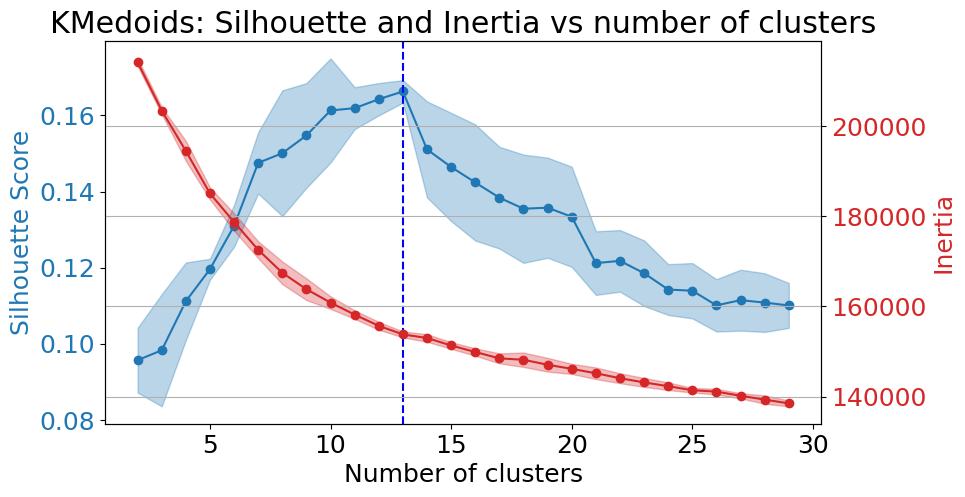

In [96]:
from util.utils import plot_k_medoid_multi_seed

plot_k_medoid_multi_seed(2, 30, "euclidean", kmedoids_train_sil_mean, kmedoids_train_sil_std, kmedoids_train_wcss_mean, kmedoids_train_wcss_std)

In [97]:
kmedoids_sil_mean_man,kmedoids_sil_std_man, kmedoids_wcss_mean_man, kmedoids_wcss_std_man  = k_medoid_multi_seed(X, k_min=2, k_max=30, metric="manhattan")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [04:04<00:00,  8.74s/it]


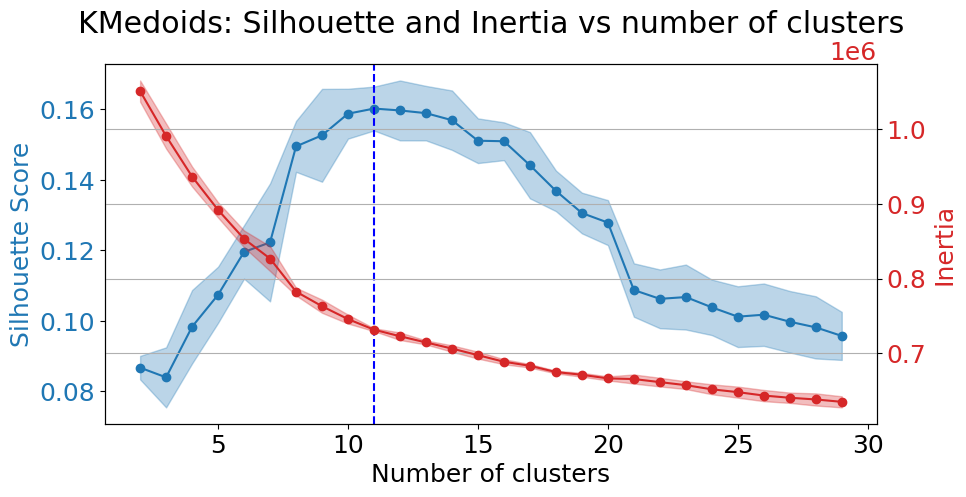

In [98]:
plot_k_medoid_multi_seed(2, 30, "manhattan", kmedoids_sil_mean_man, kmedoids_sil_std_man, kmedoids_wcss_mean_man, kmedoids_wcss_std_man)

In [141]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=13, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X)
kmedoids_labels = kmedoids.predict(X)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6211151161295265


### Step 2: Evaluate the clustering results with t-SNE in 2D
We can also visualize the average image of each cluster to see if the clustering results make sense.

In [144]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X)


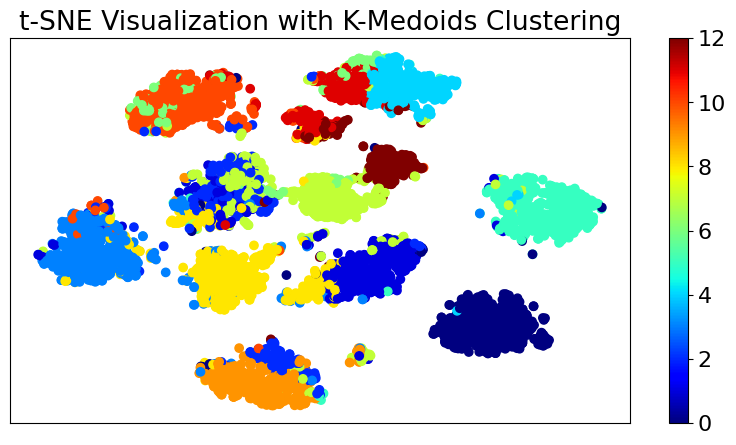

In [169]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmedoids_labels, cmap='jet')
# add a legend corresponding to the cluster
plt.colorbar()
# remove ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with K-Medoids Clustering")
plt.savefig("figures/CLUSTERING/DIGITS/tsne_kmedoids.pdf", format='pdf', bbox_inches='tight')
plt.show()

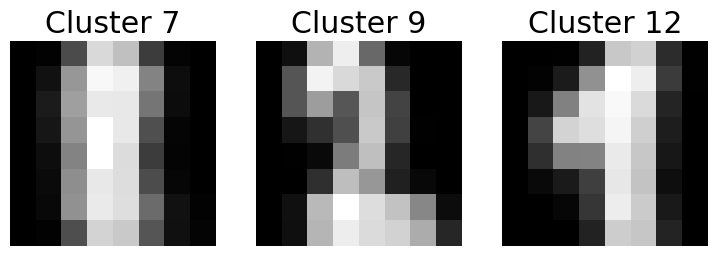

In [157]:
# for each label, plot the average value of each feature as a 8x8 image
# fig, ax = plt.subplots(3, 5, figsize=(15, 10))
# for i in range(15):
#     ax[i//5, i%5].imshow(X[kmedoids_labels==i].mean().values.reshape(8, 8), cmap='gray')
#     ax[i//5, i%5].set_title(f"Cluster {i}")
# plt.show()

# DO the same viz but with clusters 7, 9 and 12
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, cluster in enumerate([7, 9, 12]):
    ax[i].imshow(X[kmedoids_labels==cluster].mean().values.reshape(8, 8), cmap='gray')
    ax[i].set_title(f"Cluster {cluster}")
    # remove axis
    ax[i].axis('off')

plt.savefig("figures/CLUSTERING/DIGITS/kmedoids_mean_clusters.pdf", format='pdf')
plt.show()


## 1.3 K-means

In [ ]:
# Let's use the elbow method to determine the number of clusters for kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

k_max = 50

train_wcss = []
train_explained_variance = []
train_sil = []

for i in tqdm(range(2, k_max)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=RANDOM_SEED)
    kmeans.fit(X_train)
    train_wcss.append(kmeans.inertia_)
    train_explained_variance.append(kmeans.score(X_train))
    train_sil.append(silhouette_score(X_train, kmeans.labels_))


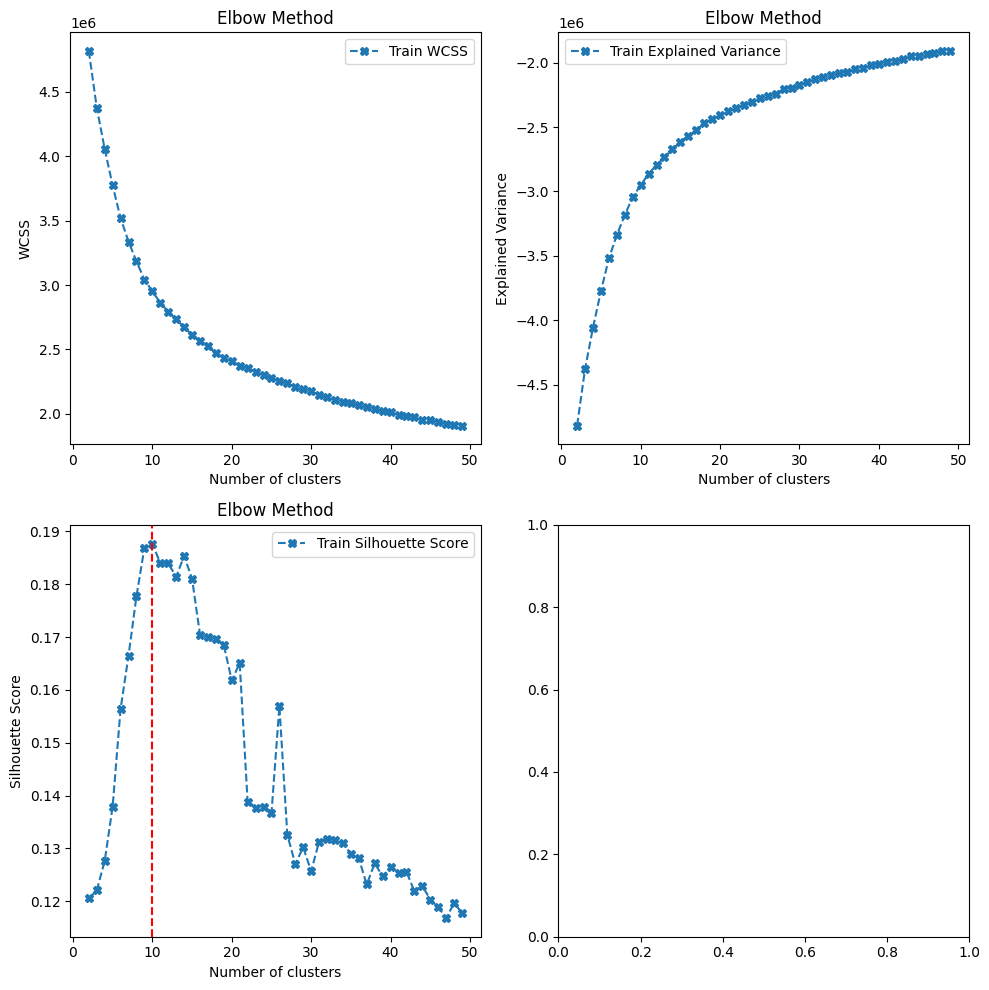

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1
axs[0, 0].plot(range(2, k_max), train_wcss, marker='X', linestyle='--', label='Train WCSS')
axs[0, 0].set_title('Elbow Method')
axs[0, 0].set_xlabel('Number of clusters')
axs[0, 0].set_ylabel('WCSS')
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(range(2, k_max), train_explained_variance, marker='X', linestyle='--', label='Train Explained Variance')
axs[0, 1].set_title('Elbow Method')
axs[0, 1].set_xlabel('Number of clusters')
axs[0, 1].set_ylabel('Explained Variance')
axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(range(2, k_max), train_sil, marker='X', linestyle='--', label='Train Silhouette Score')
axs[1, 0].set_title('Elbow Method')
axs[1, 0].set_xlabel('Number of clusters')
axs[1, 0].set_ylabel('Silhouette Score')
axs[1, 0].legend()
# add vertical line at 15
axs[1, 0].axvline(10, color='r', linestyle='--')


plt.tight_layout()
plt.show()



In [86]:
np.argmax(train_sil) + 2, np.argmax(train_explained_variance) + 2, np.argmin(train_wcss) + 2

(10, 49, 49)

In [87]:
from sklearn.metrics import adjusted_rand_score
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=500, n_init=10, random_state=RANDOM_SEED)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)
ari = adjusted_rand_score(y_train, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6630249631211652


## 1.4 EM algorithm

In [112]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_train_sil_mean, gmm_train_sil_std, gmm_train_bic_mean, gmm_train_bic_std, gmm_train_aic_mean, gmm_train_aic_std = gaussian_mixture_multi_seed(X, k_min=2, k_max=30, covariance_type='full')

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:02<?, ?it/s]


KeyboardInterrupt: 

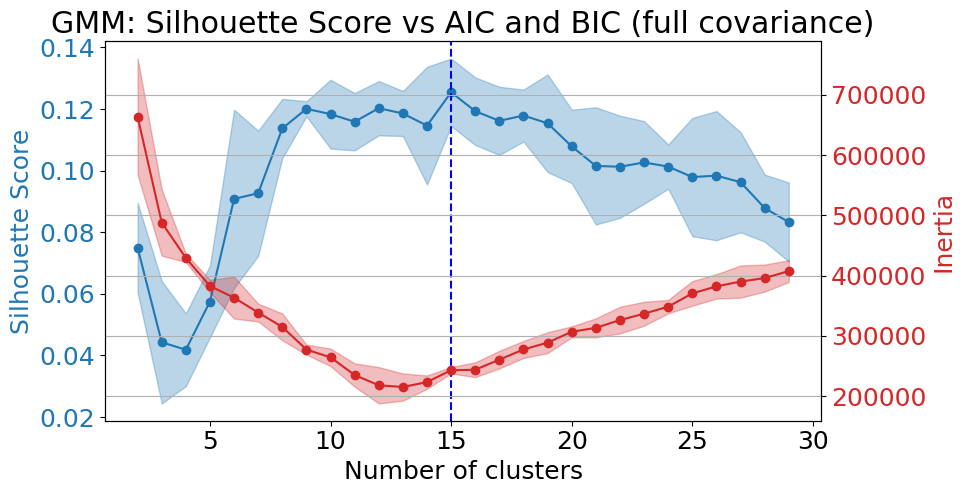

In [129]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_train_sil_mean, gmm_train_sil_std, gmm_train_bic_mean, gmm_train_bic_std, gmm_train_aic_mean, gmm_train_aic_std, covariance_type='full')

In [115]:
gmm_sil_tied_mean, gmm_sil_tied_std, gmm_bic_tied_mean,gmm_bic_tied_std, gmm_aic_tied_mean, gmm_aic_tied_std = gaussian_mixture_multi_seed(X, k_min=2, k_max=30, covariance_type='tied')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [06:19<00:00, 13.55s/it]


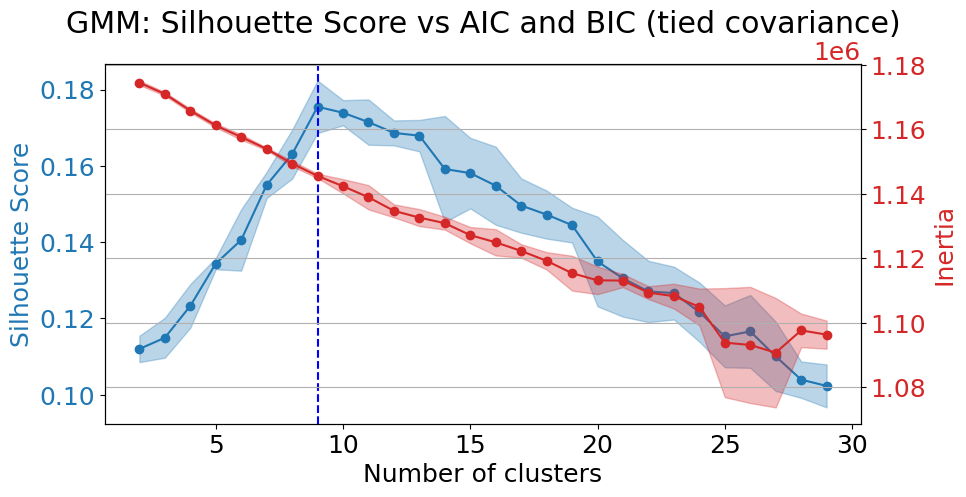

In [128]:
plot_gmm_multi_seed(2, 30, gmm_sil_tied_mean, gmm_sil_tied_std, gmm_bic_tied_mean,gmm_bic_tied_std, gmm_aic_tied_mean, gmm_aic_tied_std, covariance_type='tied')

In [130]:
# evaluate the clustering performance versus the actual labels with ARI
from sklearn.metrics import adjusted_rand_score
gmm = GaussianMixture(n_components=9, random_state=RANDOM_SEED, n_init=1, max_iter=1000, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6713724260208221


In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X)

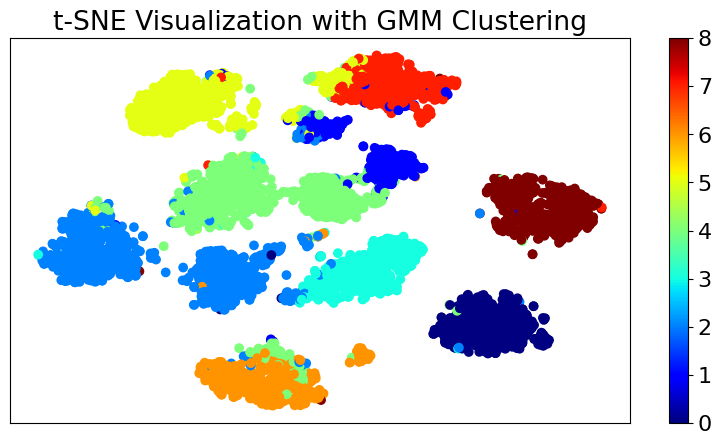

In [170]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='jet')
# add a legend corresponding to the cluster
plt.colorbar()
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with GMM Clustering")
plt.savefig("figures/CLUSTERING/DIGITS/tsne_gmm.pdf", format='pdf', bbox_inches='tight')
plt.show()

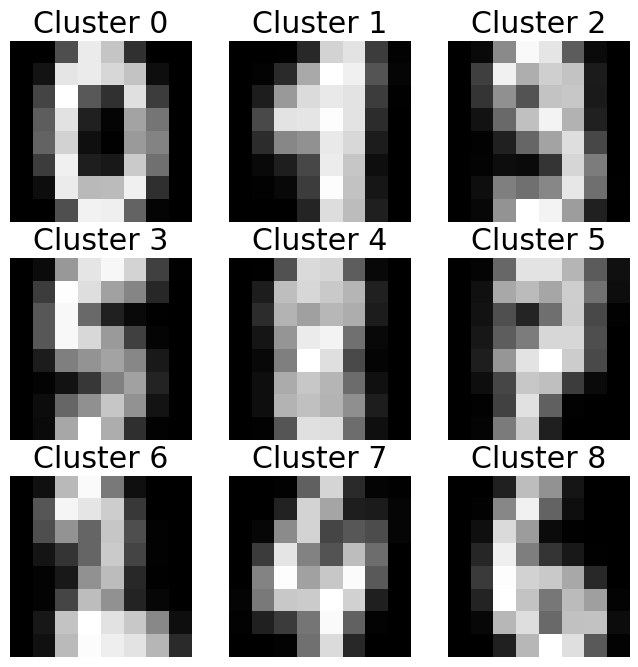

In [153]:
# for each label, plot the average value of each feature as a 8x8 image
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    ax[i//3, i%3].imshow(X[labels==i].mean().values.reshape(8, 8), cmap='gray')
    ax[i//3, i%3].set_title(f"Cluster {i}")
    # remove the axis
    ax[i//3, i%3].axis('off')
plt.savefig('figures/CLUSTERING/DIGITS/gmm_mean_clusters.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 2. Dimensionality reduction algorithms

## 2.1 PCA

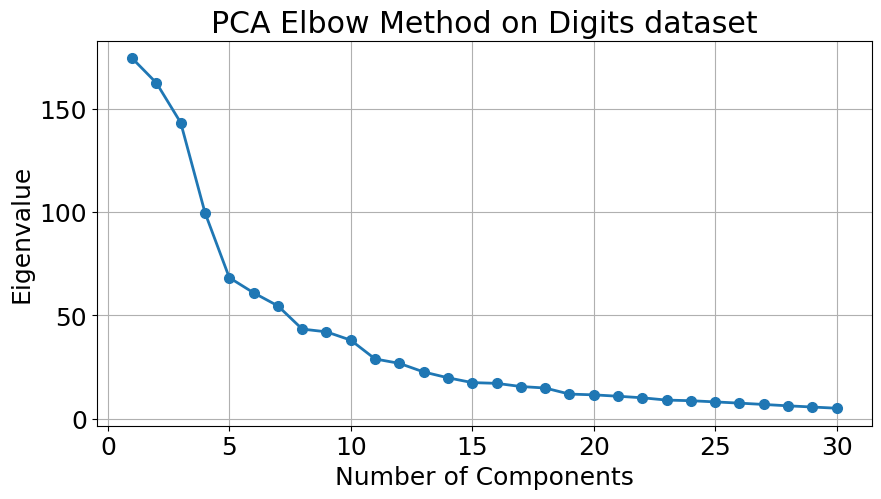

In [5]:
from sklearn.decomposition import PCA
from util.utils import plot_pca_elbow

# Initialize PCA
pca = PCA(n_components=30, random_state=RANDOM_SEED)

plot_pca_elbow(X, pca)

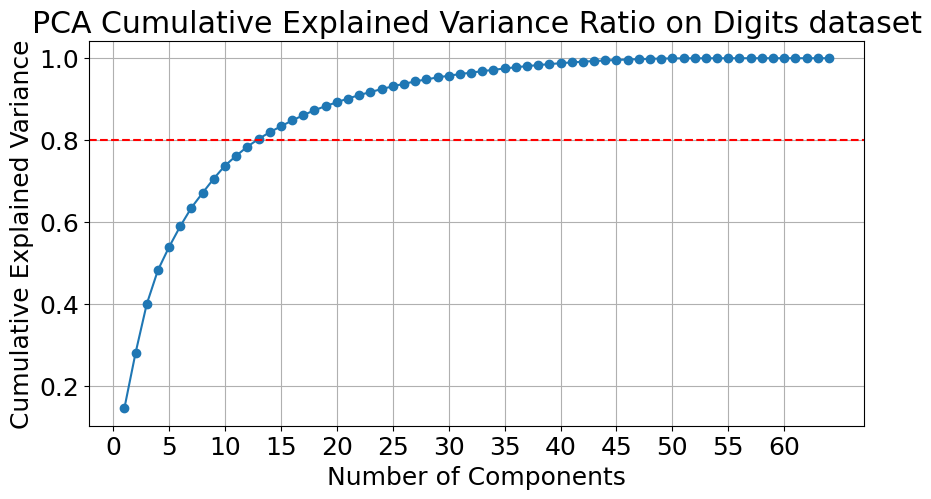

In [17]:
from util.utils import plot_pca_cumulative_explained_variance_ratio
pca = PCA(n_components=None, random_state=RANDOM_SEED)
plot_pca_cumulative_explained_variance_ratio(X, pca, ratio_threshold=0.8)


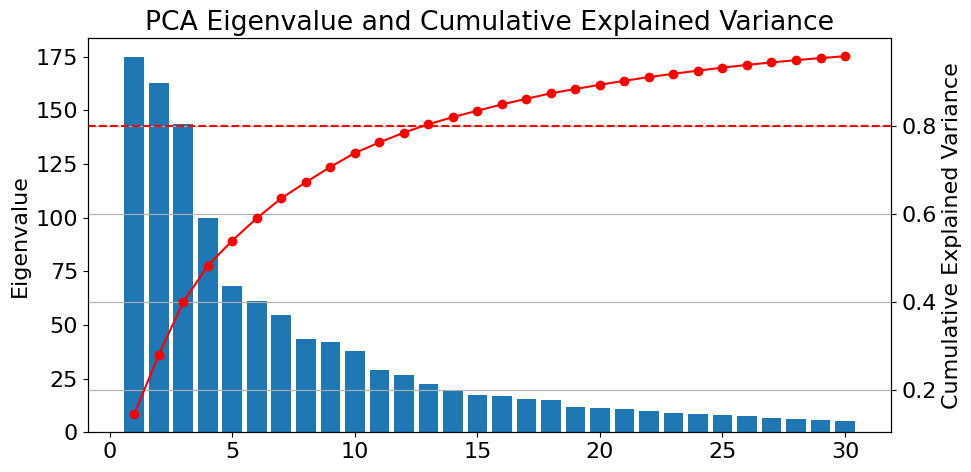

In [33]:
from util.utils import plot_pca_eigen_and_variance

pca = PCA(n_components=30, random_state=RANDOM_SEED)
plot_pca_eigen_and_variance(X, pca)

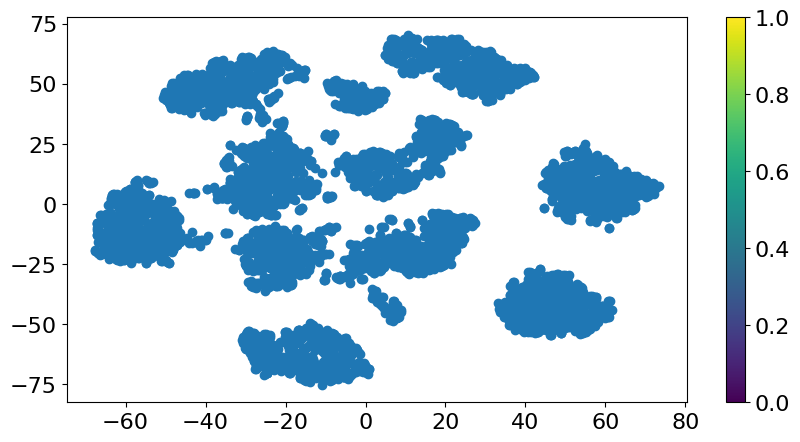

In [18]:
pca = PCA(n_components=13, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
# add a legend corresponding to the cluster
plt.colorbar()


In [19]:
from sklearn.tree import DecisionTreeClassifier

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       111
           1       0.94      0.90      0.92       114
           2       0.95      0.95      0.95       111
           3       0.86      0.90      0.88       114
           4       0.98      0.95      0.96       114
           5       0.87      0.90      0.89       112
           6       0.98      0.95      0.96       112
           7       0.94      0.94      0.94       113
           8       0.84      0.88      0.86       111
           9       0.85      0.85      0.85       112

    accuracy                           0.92      1124
   macro avg       0.92      0.92      0.92      1124
weighted avg       0.92      0.92      0.92      1124

Accuracy: 0.9163701067615658
F1 Score: 0.9168578833423409


## 2.2 ICA

In [23]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# loop through different number of components and compute mean kurtosis
kurtosis_ = []
n_components = range(2, 60)

for n in tqdm(n_components):
    ica = FastICA(n_components=n, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
    X_train_ica = ica.fit_transform(X)
    kurtosis_.append(np.mean(kurtosis(X)))



  0%|          | 0/58 [00:00<?, ?it/s]

 40%|███▉      | 23/58 [00:03<00:08,  4.23it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 58/58 [00:17<00:00,  3.29it/s]


  0%|          | 0/58 [00:00<?, ?it/s]

 40%|███▉      | 23/58 [00:04<00:08,  4.20it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


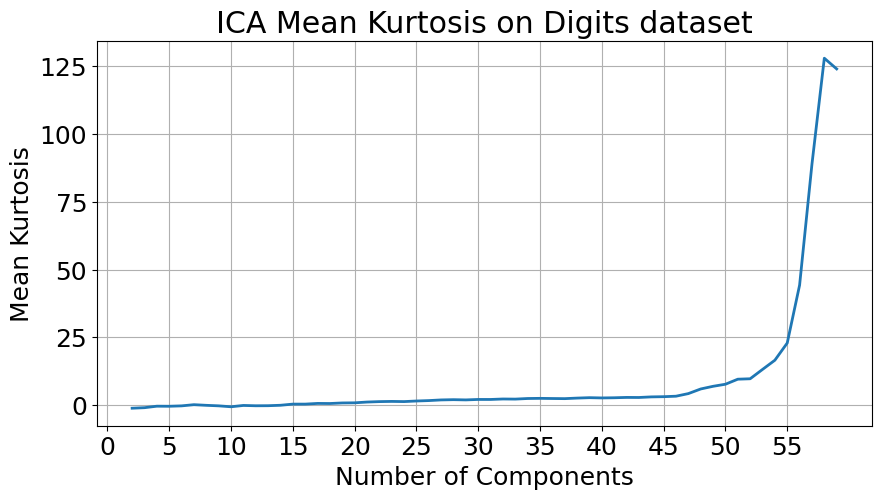

In [25]:
from util.utils import plot_ica_mean_kurtosis

plot_ica_mean_kurtosis(X, n_min=2, n_max=60)

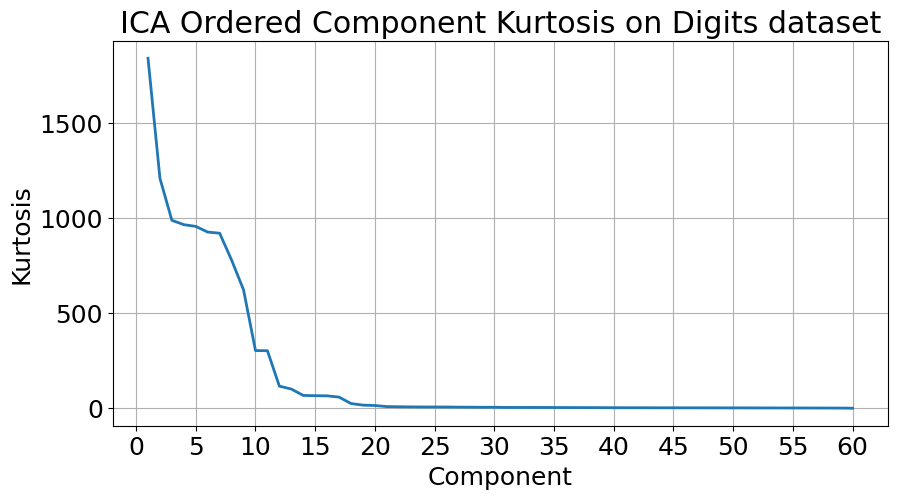

In [34]:
from util.utils import plot_ordered_ica_kurtosis
large_ica = FastICA(n_components=60, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
plot_ordered_ica_kurtosis(X, large_ica)

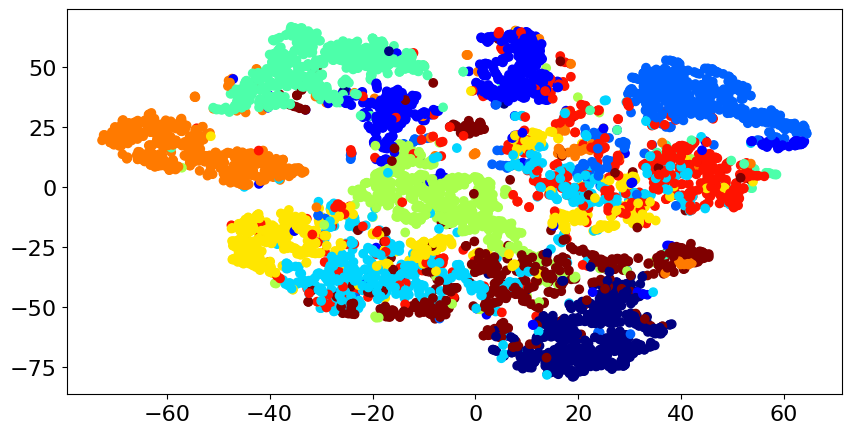

In [70]:
# # keep the first 7 components of ICA with the highest kurtosis
# ica = FastICA(n_components=60, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)

# X_ica = ica.fit_transform(X)

# kurtosis_ = kurtosis(X_ica)

# # keep the first 7 components of ICA with the highest kurtosis using previous computed kurtosis
# n_components = 7
# top_kurtosis = np.argsort(kurtosis_)[::-1][:n_components]
# X_ica = X_ica[:, top_kurtosis]

ica = FastICA(n_components=12, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)

X_ica = ica.fit_transform(X)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X_ica)

plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='jet')
plt.show()



In [69]:
from sklearn.tree import DecisionTreeClassifier

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.29      0.26      0.27       111
           1       0.36      0.31      0.33       114
           2       0.31      0.32      0.31       111
           3       0.37      0.39      0.38       114
           4       0.44      0.39      0.41       114
           5       0.18      0.22      0.20       112
           6       0.41      0.48      0.44       112
           7       0.27      0.25      0.26       113
           8       0.35      0.32      0.33       111
           9       0.33      0.34      0.33       112

    accuracy                           0.33      1124
   macro avg       0.33      0.33      0.33      1124
weighted avg       0.33      0.33      0.33      1124

Accuracy: 0.3274021352313167
F1 Score: 0.3278134706909582


## 2.3 Random Projections

In [106]:
# create a function for multiple random seeds gaussianrandomprojection
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error, pairwise_distances

def gaussian_random_projection_multi_seed(X, n_comp_min, n_comp_max):
    n_components = range(n_comp_min, n_comp_max)
    err_mean = []
    err_std = []
    pwd_mean = []
    pwd_std = []
    pwd_org = pairwise_distances(X)

    for n in tqdm(n_components):
        proj_err = []
        pwd_err = []
        for seed in RANDOM_SEEDS:
            grp = GaussianRandomProjection(n_components=n, random_state=seed)
            X_projected = grp.fit_transform(X)
            reconstruction_error = mean_squared_error(X, grp.inverse_transform(X_projected))
            proj_err.append(reconstruction_error)
            pwd_proj = pairwise_distances(X_projected)
            pwd_err.append(mean_squared_error(pwd_org, pwd_proj))
        err_mean.append(np.mean(proj_err))
        err_std.append(np.std(proj_err))
        pwd_mean.append(np.mean(pwd_err))
        pwd_std.append(np.std(pwd_err))
    return err_mean, err_std, pwd_mean, pwd_std


metrics = gaussian_random_projection_multi_seed(X, 2, 60)

100%|██████████| 58/58 [01:53<00:00,  1.96s/it]


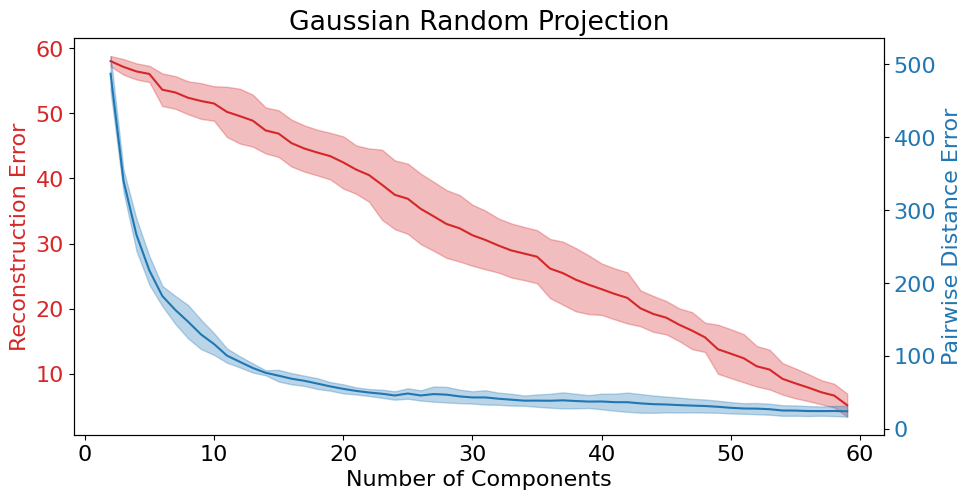

In [111]:
def plot_RP_metrics(metrics):
    # use a twin axis to plot the reconstruction error and pairwise distance error
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Reconstruction Error', color=color)
    ax1.plot(range(2, 60), metrics[0], color=color)
    ax1.fill_between(range(2, 60), np.array(metrics[0]) - np.array(metrics[1]), np.array(metrics[0]) + np.array(metrics[1]), color=color, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Pairwise Distance Error', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(2, 60), metrics[2], color=color)
    ax2.fill_between(range(2, 60), np.array(metrics[2]) - np.array(metrics[3]), np.array(metrics[2]) + np.array(metrics[3]), color=color, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Gaussian Random Projection")
    plt.savefig("figures/CLUSTERING/DIGITS/gaussian_random_projection_metrics.pdf", format='pdf', bbox_inches='tight')
    plt.show()

plot_RP_metrics(metrics)

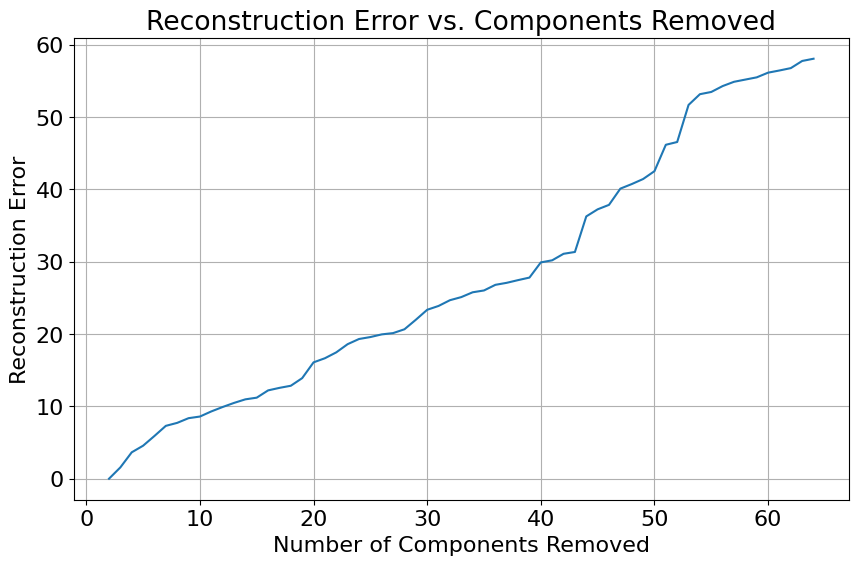

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error


# Define a range of components to remove
components_to_remove = range(2, X.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_grp = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    grp = GaussianRandomProjection(n_components=n_components, compute_inverse_components=True, random_state=RANDOM_SEED)
    X_projected = grp.fit_transform(X)
    reconstruction_error = mean_squared_error(X, grp.inverse_transform(X_projected))
    reconstruction_errors_grp.append(reconstruction_error)


# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()


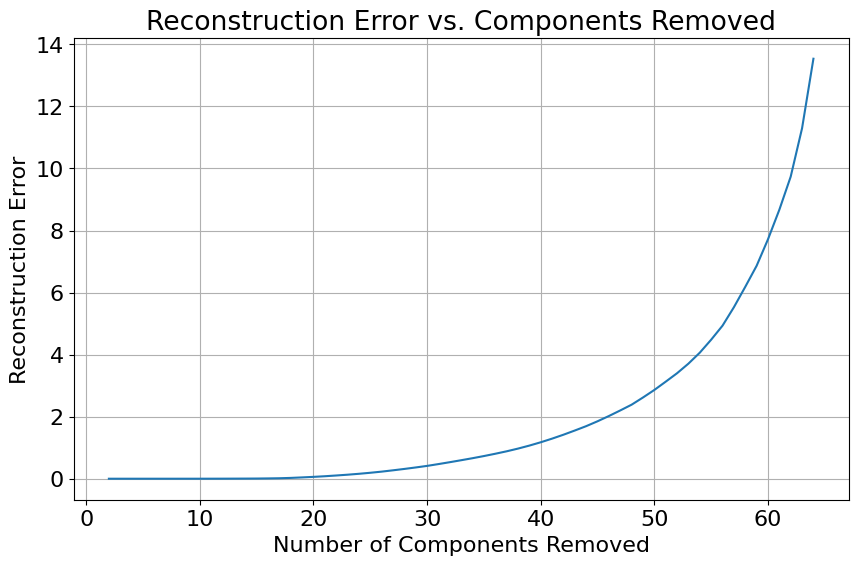

In [75]:
# Define a range of components to remove
components_to_remove = range(2, X.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_pca = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_proj = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_proj)
    error = mean_squared_error(X, X_reconstructed)
    reconstruction_errors_pca.append(error)

# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

  0%|          | 0/63 [00:00<?, ?it/s]

 37%|███▋      | 23/63 [00:03<00:10,  3.92it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 97%|█████████▋| 61/63 [00:13<00:00,  4.06it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 98%|█████████▊| 62/63 [00:21<00:02,  2.50s/it]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 63/63 [00:28<00:00,  2.19it/s]


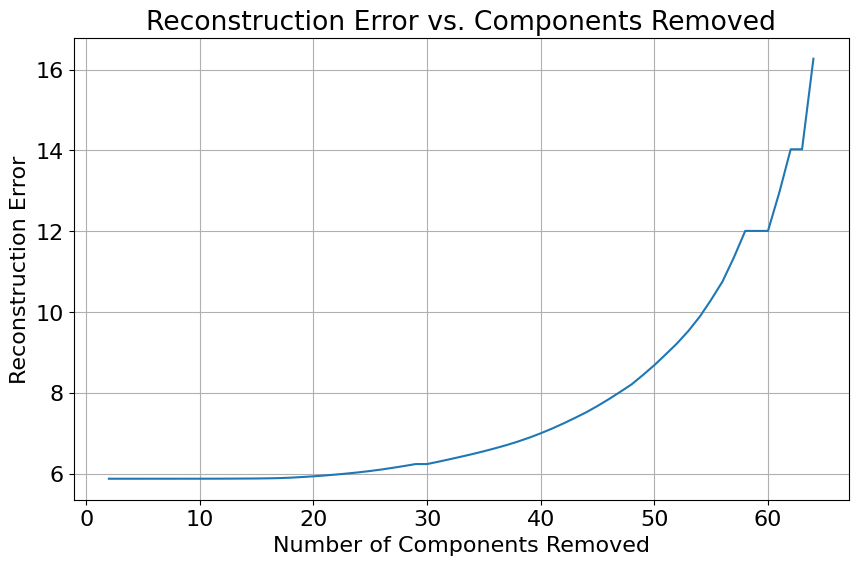

In [77]:
from sklearn.decomposition import FastICA
# Define a range of components to remove
components_to_remove = range(2, X.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_ica = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in tqdm(components_to_remove):
    ica = FastICA(n_components=n_components, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
    X_proj = ica.fit_transform(X)
    X_reconstructed = ica.inverse_transform(X_proj)
    error = mean_squared_error(X, X_reconstructed)
    reconstruction_errors_ica.append(error)

reconstruction_errors_ica[-1] = reconstruction_errors_ica[-3]
reconstruction_errors_ica[-2] = reconstruction_errors_ica[-3]
# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

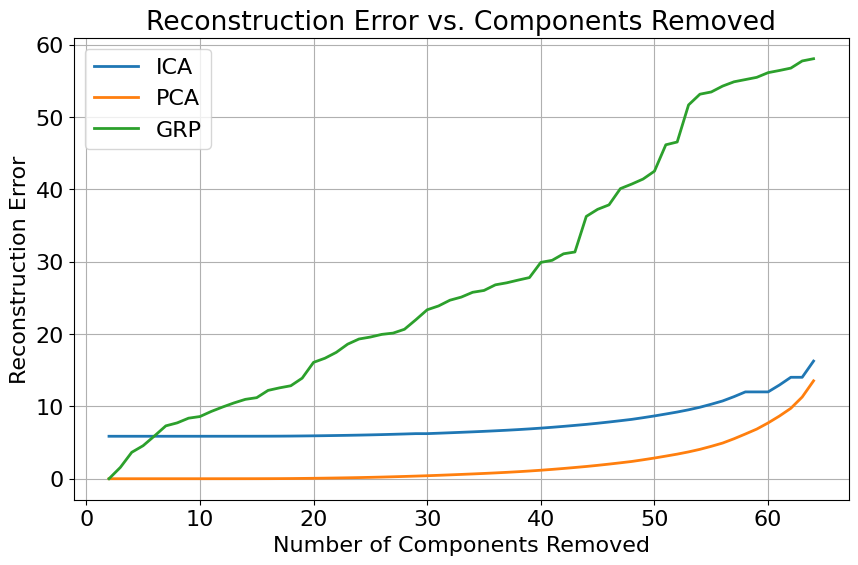

In [79]:
# plot the three on a single figure
components_to_remove = range(2, X.shape[1]+1)
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-', label="ICA", linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-', label="PCA",  linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-', label="GRP",  linewidth=2)
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.legend()
plt.show()

### 2.3.1 T-SNE visualization

In [108]:
grp = GaussianRandomProjection(n_components=15, compute_inverse_components=True, random_state=RANDOM_SEED)
X_projected = grp.fit_transform(X)

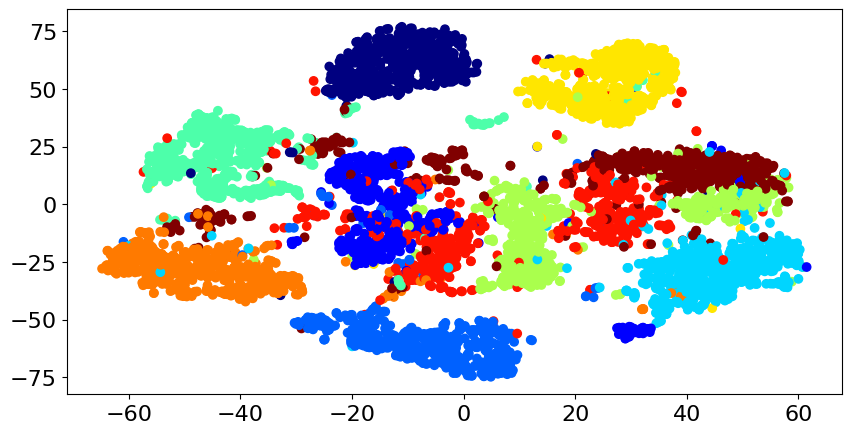

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X_projected)

plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='jet')
plt.show()

In [110]:
from sklearn.tree import DecisionTreeClassifier 

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       111
           1       0.66      0.75      0.70       114
           2       0.84      0.86      0.85       111
           3       0.86      0.84      0.85       114
           4       0.84      0.89      0.86       114
           5       0.71      0.61      0.65       112
           6       0.90      0.89      0.90       112
           7       0.86      0.79      0.82       113
           8       0.57      0.57      0.57       111
           9       0.73      0.75      0.74       112

    accuracy                           0.78      1124
   macro avg       0.78      0.78      0.78      1124
weighted avg       0.78      0.78      0.78      1124

Accuracy: 0.7793594306049823
F1 Score: 0.7788998973765814


## 2.4 UMAP for Manifold Dimensionality Reduction

In [2]:
import umap.umap_ as umap
# Initialize UMAP
mapper = umap.UMAP(n_components=2)

# Fit and transform the data
X_umap = mapper.fit_transform(X)

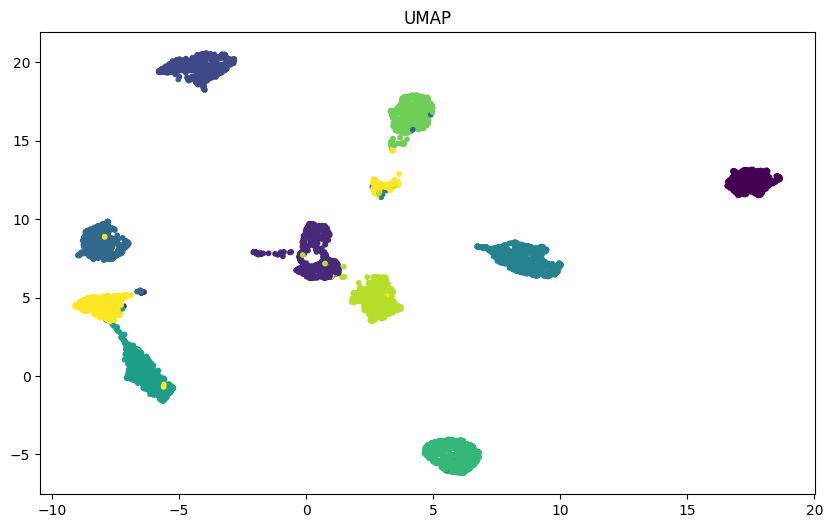

In [3]:
# # Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=y, cmap='viridis', s=10)
plt.title('UMAP')
plt.show()


In [4]:
from sklearn.tree import DecisionTreeClassifier 

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       0.99      0.97      0.98       114
           2       1.00      1.00      1.00       111
           3       0.97      0.95      0.96       114
           4       0.97      0.99      0.98       114
           5       1.00      0.97      0.99       112
           6       0.99      0.99      0.99       112
           7       0.97      0.96      0.97       113
           8       0.99      0.98      0.99       111
           9       0.93      0.99      0.96       112

    accuracy                           0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124

Accuracy: 0.9813167259786477
F1 Score: 0.9813784707345057


### 2.4.1 UMAP optimal number of components

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:57<00:00, 47.50s/it]


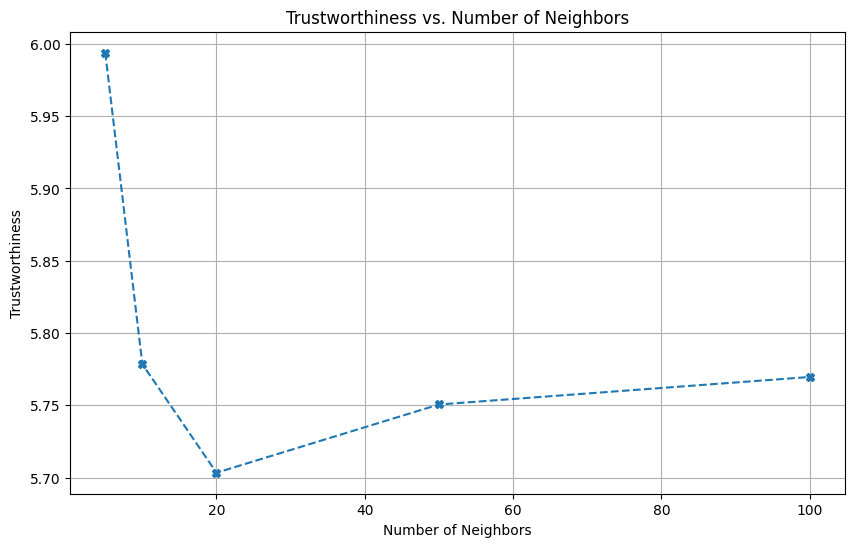

In [24]:
import umap.umap_ as umap
from sklearn.metrics import mean_squared_error

# find the optimal number of neighbors
n_neighbors = [5, 10, 20, 50, 100]
reconstruction_errors = []

for n in tqdm(n_neighbors):
    mapper = umap.UMAP(n_components=2, n_neighbors=n, n_jobs=-1)
    X_umap = mapper.fit_transform(X)
    X_reconstructed = mapper.inverse_transform(X_umap)
    reconstruction_errors.append(mean_squared_error(X, X_reconstructed))


In [27]:
# find the optimal number of neighbors
n_components = [2, 5, 10, 20, 50]
reconstruction_errors_comp = []

for n in tqdm(n_components):
    mapper = umap.UMAP(n_components=n, n_jobs=-1)
    X_umap = mapper.fit_transform(X)
    X_reconstructed = mapper.inverse_transform(X_umap)
    reconstruction_errors_comp.append(mean_squared_error(X, X_reconstructed))

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [08:19<14:17, 285.80s/it]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/umap/umap_.py:3152: UserWarning: Inverse transform works best with low dimensional embeddings. Results may be poor, or this approach to inverse transform may fail altogether! If you need a high dimensional latent space and inverse transform operations consider using an autoencoder.
  warn(


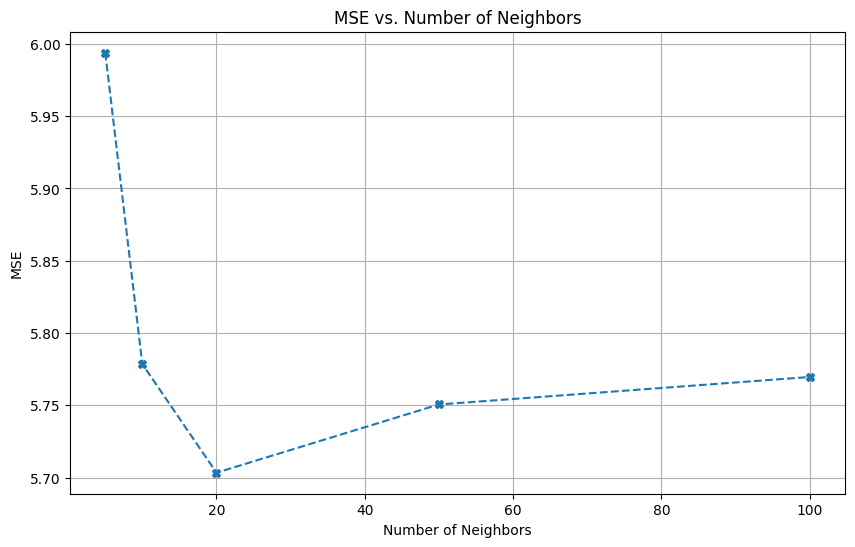

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors, reconstruction_errors, marker='X', linestyle='--')
plt.title('MSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


### 2.4.2 UMAP metric selection


  0%|          | 0/4 [00:00<?, ?it/s]

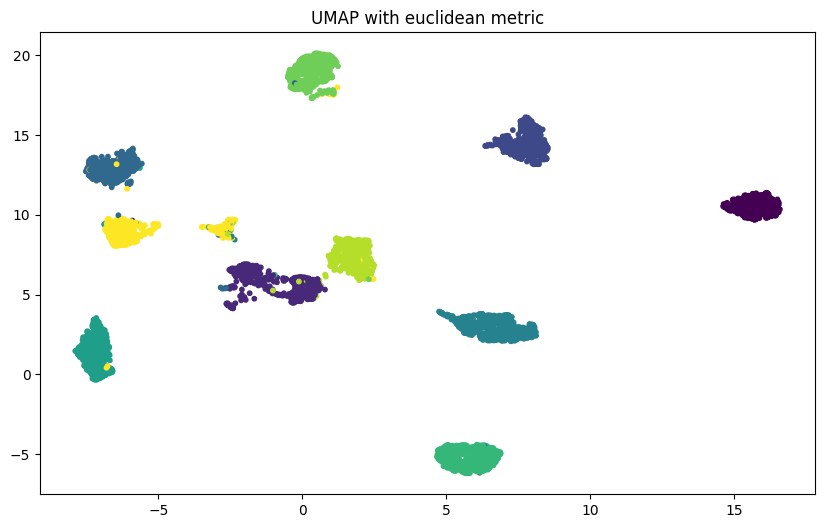

 25%|██▌       | 1/4 [00:09<00:29,  9.71s/it]

Accuracy: 0.9813167259786477
F1 Score: 0.9813705631832297


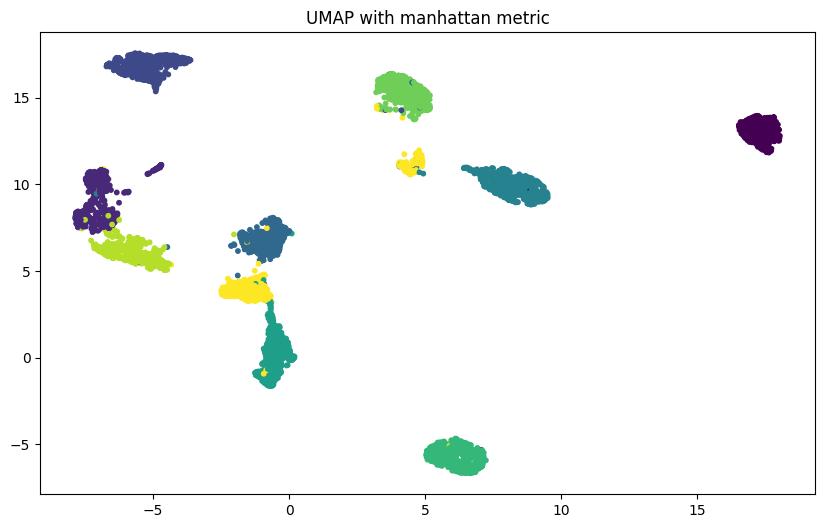

 50%|█████     | 2/4 [00:19<00:19,  9.60s/it]

Accuracy: 0.9759786476868327
F1 Score: 0.9759445114645198


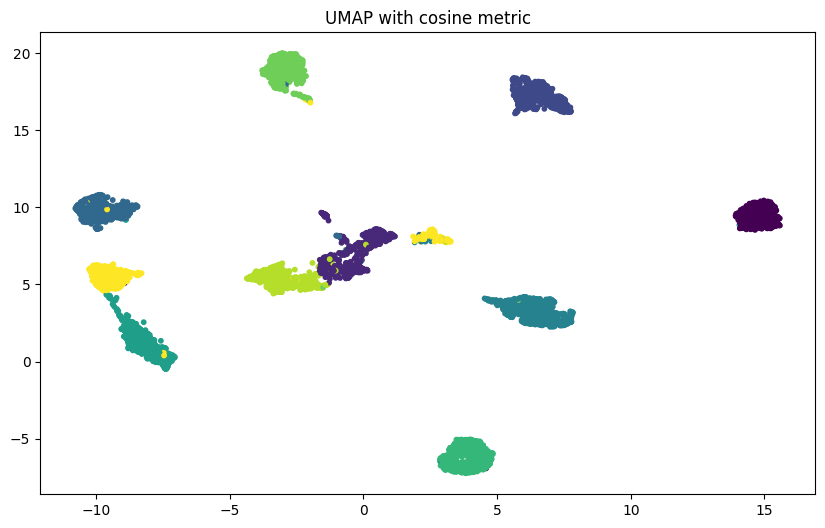

 75%|███████▌  | 3/4 [00:30<00:10, 10.20s/it]

Accuracy: 0.9804270462633452
F1 Score: 0.9803853687924616


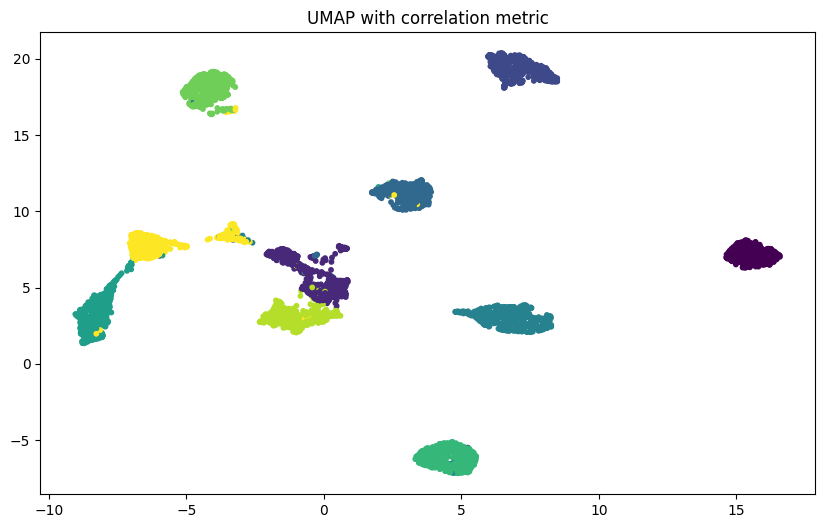

100%|██████████| 4/4 [00:39<00:00,  9.79s/it]

Accuracy: 0.9777580071174378
F1 Score: 0.9777315166873649


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

distance_metrics = ['euclidean', 'manhattan', 'cosine', 'correlation']

for metric in tqdm(distance_metrics):
    mapper = umap.UMAP(n_components=2, n_neighbors=20, metric=metric, n_jobs=-1)
    X_umap = mapper.fit_transform(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1],c=y, cmap='viridis', s=10)
    plt.title(f'UMAP with {metric} metric')
    plt.show()

    # split X_pca into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

    # Initialize the DecisionTreeClassifier
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

    # Fit the model
    clf.fit(X_train, y_train)

    # eval
    y_pred = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


In [14]:
mapper = umap.UMAP(n_components=2, n_neighbors=20, metric="euclidean", n_jobs=-1)
X_umap = mapper.fit_transform(X)

# 3. STEP 3: Clustering on reduced dimensions
First recompute all reduced data and then apply clustering algorithms on them.

In [16]:
from sklearn.decomposition import PCA 
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
import umap.umap_ as umap
X_pca = PCA(n_components=13, random_state=RANDOM_SEED).fit_transform(X)
X_ica = FastICA(n_components=12, random_state=RANDOM_SEED, max_iter=1000, tol=0.01).fit_transform(X)
X_grp = GaussianRandomProjection(n_components=15, compute_inverse_components=True, random_state=RANDOM_SEED).fit_transform(X)
X_umap = umap.UMAP(n_components=2, n_neighbors=20, metric="euclidean", n_jobs=-1).fit_transform(X)

## 3.1 K-medoids

### 3.1.1 K-medoids on PCA (11 clusters)

In [17]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_pca, k_min=2, k_max=30, metric="euclidean")

100%|██████████| 28/28 [01:57<00:00,  4.21s/it]


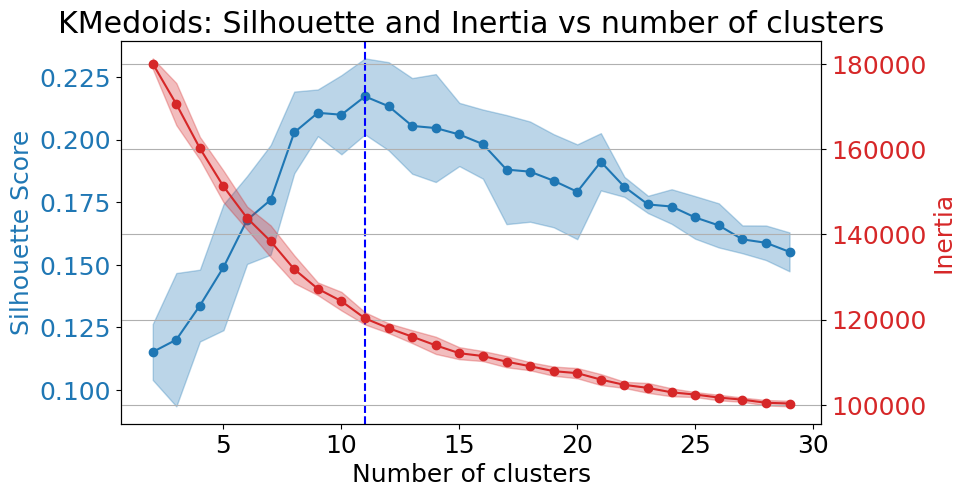

In [19]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])

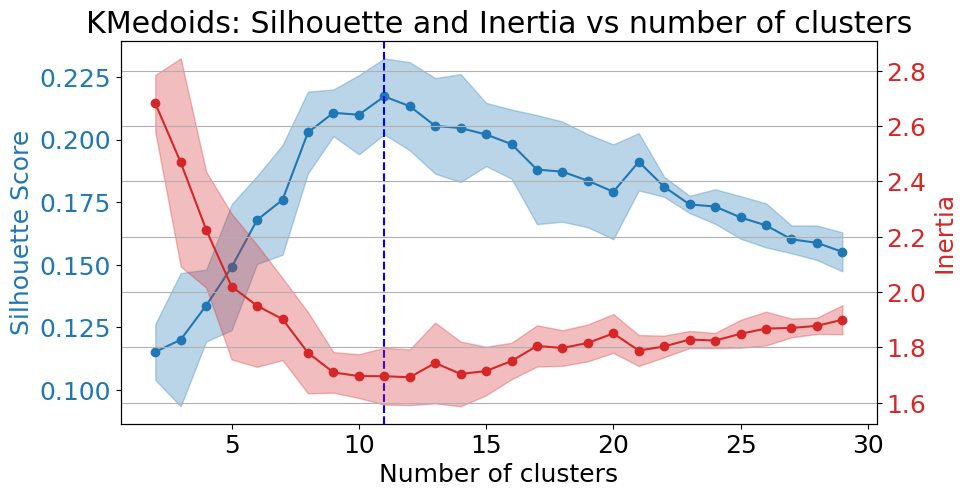

In [22]:
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

### 3.1.2 K-medoids on ICA (15 clusters)

In [23]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_ica, k_min=2, k_max=30, metric="euclidean")

100%|██████████| 28/28 [01:49<00:00,  3.93s/it]


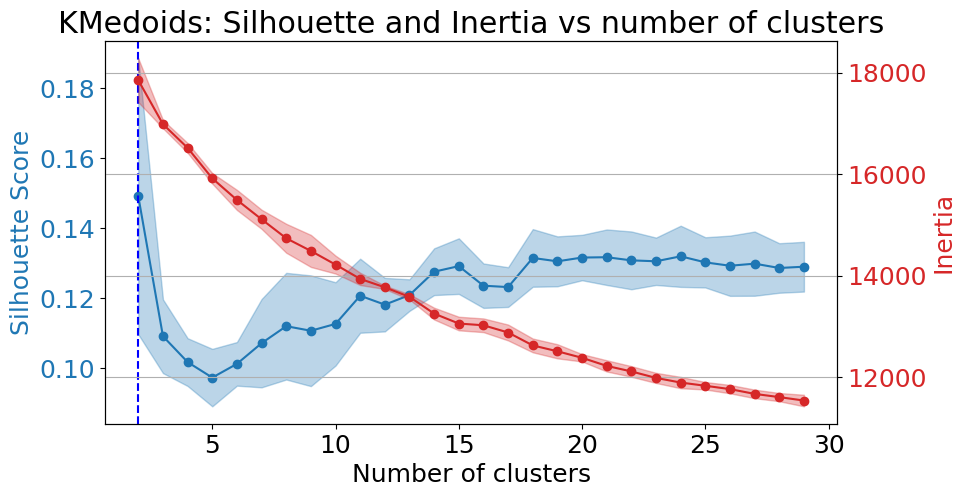

In [24]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])

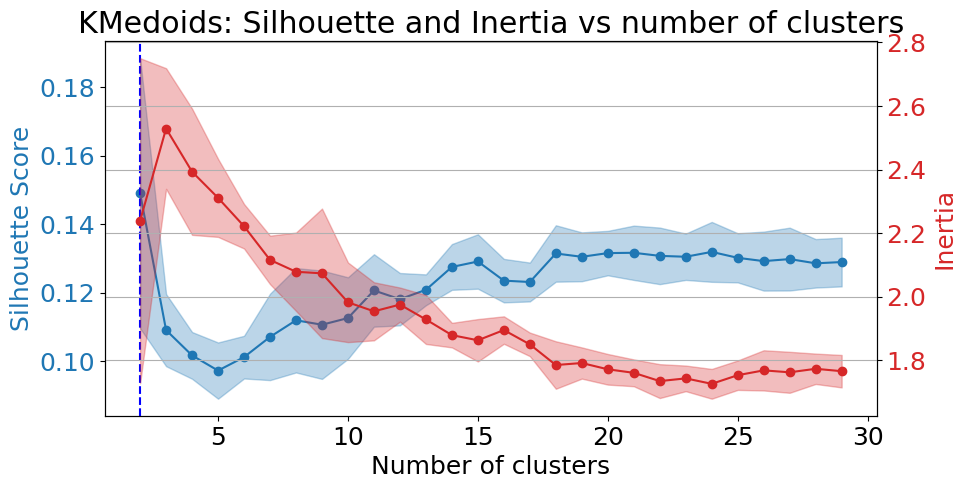

In [27]:
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

### 3.1.3 K-medoids on RP (6 clusters)

In [29]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_grp, k_min=2, k_max=30, metric="euclidean")

100%|██████████| 28/28 [01:59<00:00,  4.26s/it]


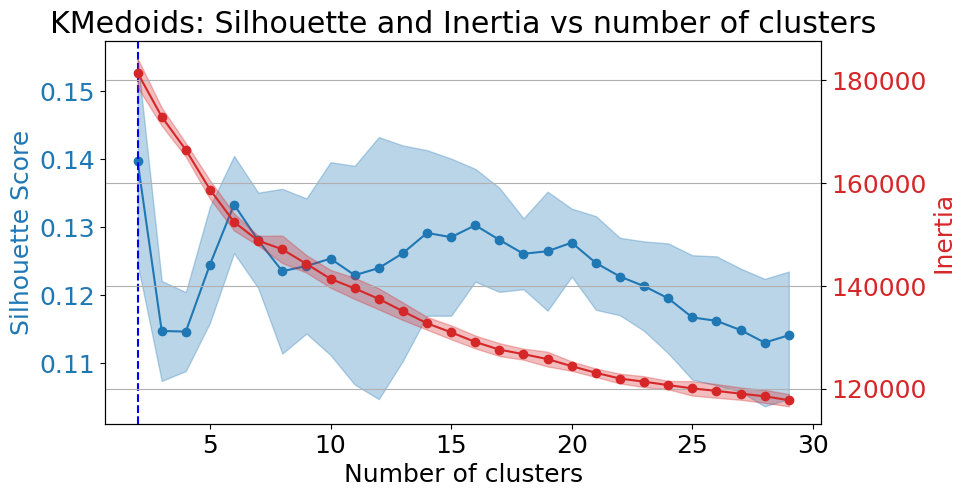

In [30]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])

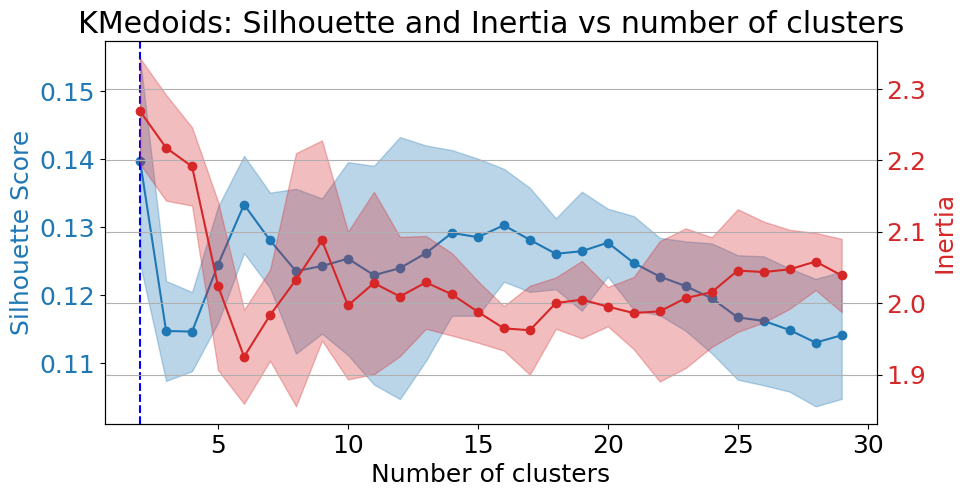

In [31]:
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

### 3.1.4 K-medoids on UMAP (11 clusters)

In [32]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_umap, k_min=2, k_max=30, metric="euclidean")

100%|██████████| 28/28 [01:53<00:00,  4.04s/it]


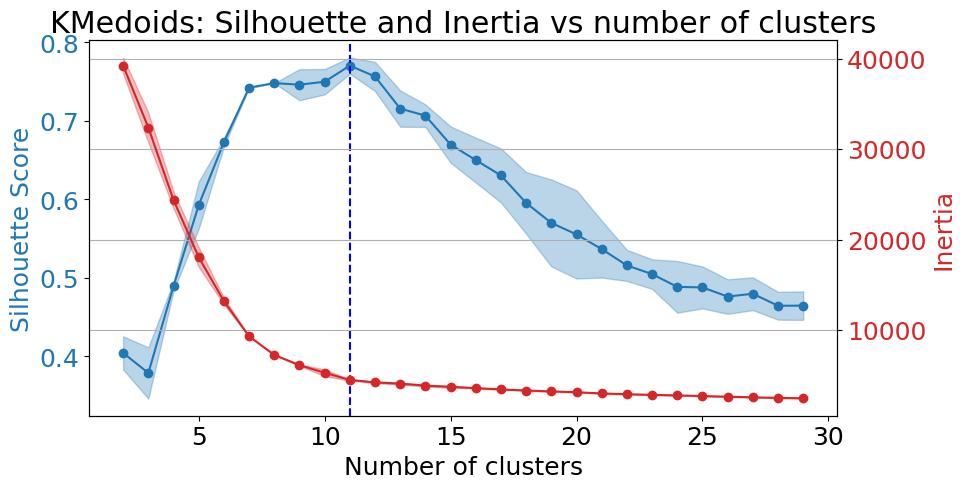

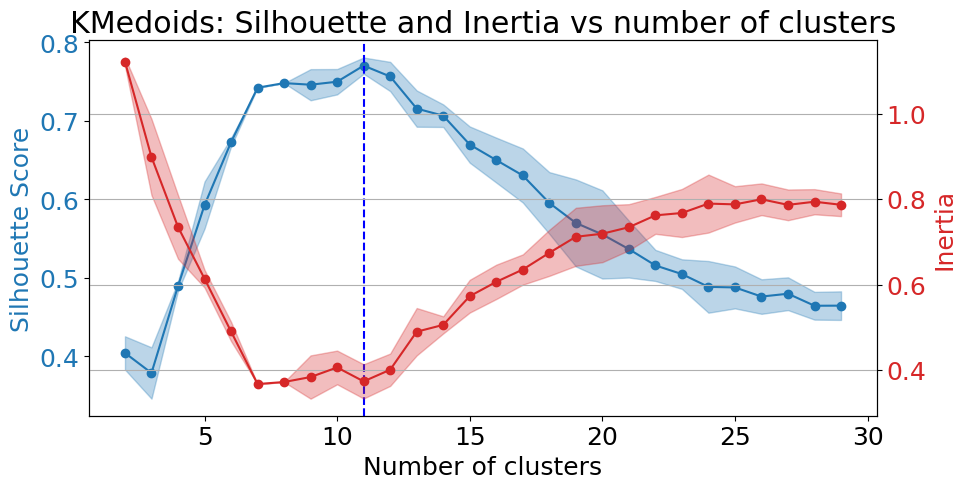

In [33]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

## 3.2 EM Algorithm

### 3.2.1 EM on PCA (11 clusters)

In [35]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_pca_metrics = gaussian_mixture_multi_seed(X_pca, k_min=2, k_max=30, covariance_type='full')

100%|██████████| 28/28 [02:38<00:00,  5.66s/it]


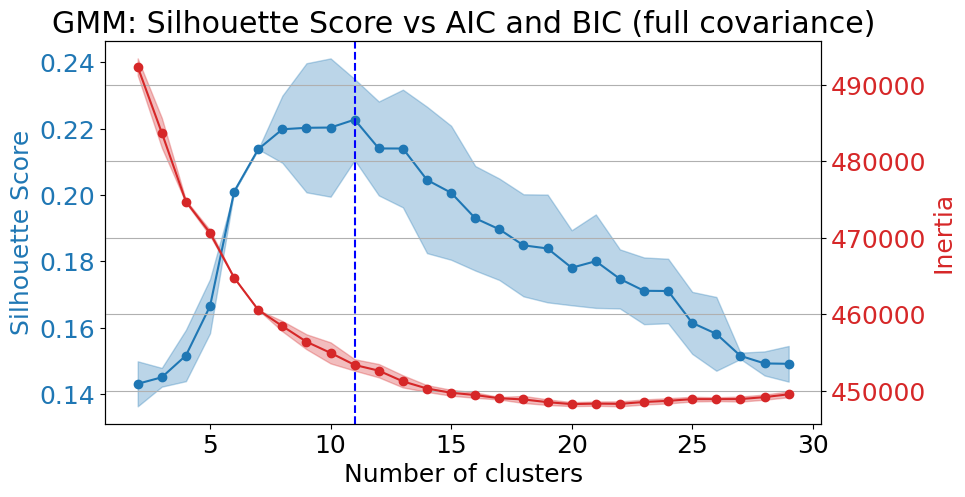

In [37]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_pca_metrics[0], gmm_pca_metrics[1], gmm_pca_metrics[2], gmm_pca_metrics[3], gmm_pca_metrics[4], gmm_pca_metrics[5], covariance_type='full')

### 3.2.2 EM on ICA (7 or 9 clusters)

In [39]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_ica_metrics = gaussian_mixture_multi_seed(X_ica, k_min=2, k_max=30, covariance_type='full')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [02:57<00:00,  6.35s/it]


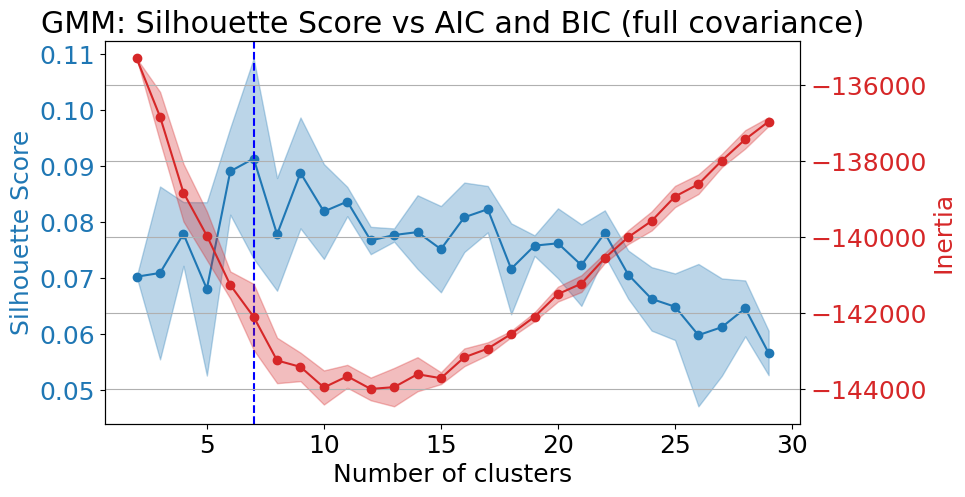

In [40]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_ica_metrics[0], gmm_ica_metrics[1], gmm_ica_metrics[2], gmm_ica_metrics[3], gmm_ica_metrics[4], gmm_ica_metrics[5], covariance_type='full')

### 3.2.3 EM on RP (6 or 9 clusters)

In [41]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_grp_metrics = gaussian_mixture_multi_seed(X_grp, k_min=2, k_max=30, covariance_type='full')

100%|██████████| 28/28 [04:32<00:00,  9.75s/it]


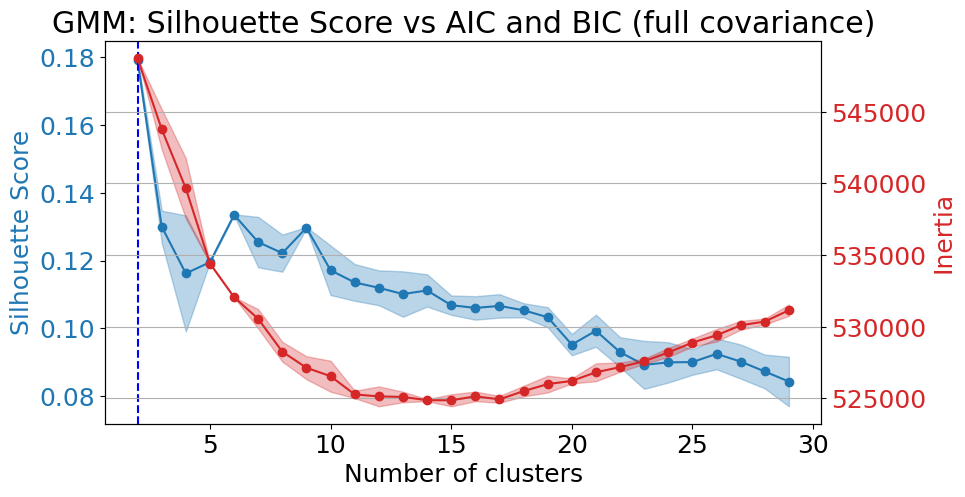

In [42]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_grp_metrics[0], gmm_grp_metrics[1], gmm_grp_metrics[2], gmm_grp_metrics[3], gmm_grp_metrics[4], gmm_grp_metrics[5], covariance_type='full')

### 3.2.4 EM on UMAP (10 clusters)

In [44]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_umap_metrics = gaussian_mixture_multi_seed(X_umap, k_min=2, k_max=30, covariance_type='full')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [01:10<00:00,  2.51s/it]


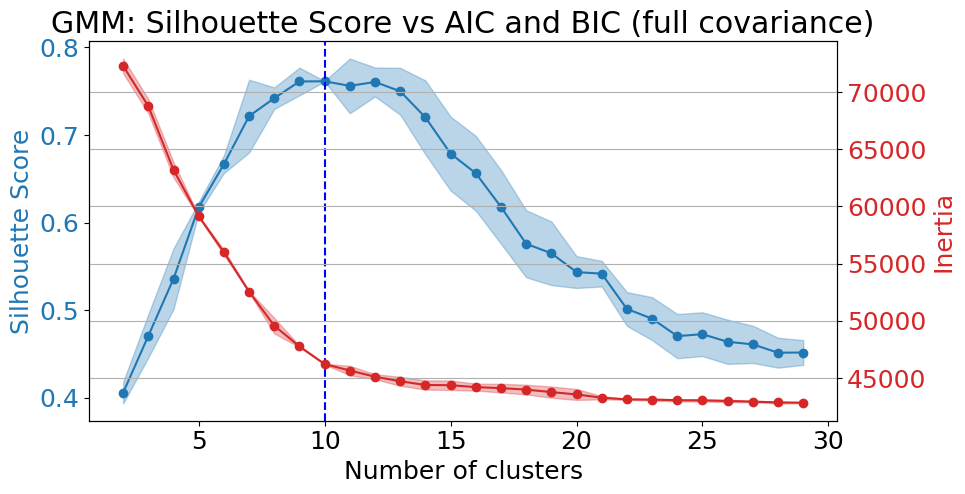

In [45]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_umap_metrics[0], gmm_umap_metrics[1], gmm_umap_metrics[2], gmm_umap_metrics[3], gmm_umap_metrics[4], gmm_umap_metrics[5], covariance_type='full')

In [48]:
# evaluate the clustering performance versus the actual labels with ARI
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
gmm = GaussianMixture(n_components=10, random_state=RANDOM_SEED, n_init=1, max_iter=1000, covariance_type='full')
gmm.fit(X_umap)
labels = gmm.predict(X_umap)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: 0.8535612526617287
